# Chicago L Ridership

This Jupyter Notebook analyzes the ridership of the Chicago e"L"evated public transportation system. Ridership numbers come from Chicago's open data portal, found here: https://data.cityofchicago.org/Transportation/CTA-Ridership-L-Station-Entries-Daily-Totals/5neh-572f

In [1]:
# Import pandas for our data analysis
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline
plt.style.use('ggplot')

The questions of interest are: 

1. Which stop has the highest average ridership per day, and what is it?
2. Which stop has the greatest standard deviation in weekday (exclude holidays) ridership per day, and what is it?

I will go about this by importing the data into a pandas DataFrame, then grouping the ridership numbers by station and filtering as appropriate to determine the variables of interest.

In [2]:
ridership = pd.read_csv('ridership.csv')
ridership.date = pd.to_datetime(ridership.date, dayfirst=False, format='%m/%d/%Y')
print(ridership.head())
print(ridership.shape)
print(ridership.dtypes)

   station_id         stationname       date daytype  rides
0       40010  Austin-Forest Park 2001-01-01       U    290
1       40020         Harlem-Lake 2001-01-01       U    633
2       40030        Pulaski-Lake 2001-01-01       U    483
3       40040        Quincy/Wells 2001-01-01       U    374
4       40050               Davis 2001-01-01       U    804
(826894, 5)
station_id              int64
stationname            object
date           datetime64[ns]
daytype                object
rides                   int64
dtype: object


So we now have the full dataset in our DataFrame - 826,894 entries.

## Question 1
Now let's try to answer the first question about highest average ridership. We'll accomplish this by using pandas' `groupby` functionality to group the DataFrame by each `stationname`, take the mean of the number of rides over the whole time period, then sort by that average to find the highest-ridership stations.

In [3]:
mean_ridership = ridership.groupby(by='stationname')['rides'].mean()
mean_ridership.sort_values(ascending=False, inplace=True)
mean_ridership.head()

stationname
Clark/Lake            13661.190402
Lake/State            13299.597592
Chicago/State         12944.953208
95th/Dan Ryan         10859.289046
Belmont-North Main    10440.290384
Name: rides, dtype: float64

### Question 1 Answer
So it looks like *Clark/Lake* is the stop with the highest average ridership over the time period measured, with about 13,661 riders per day entering at that station. To make sure we didn't make any errors in our analysis, let's just take a quick look at *only* the Clark/Lake numbers

In [4]:
# Sanity check
ridership[ridership['stationname'] == 'Clark/Lake'].describe()

,station_id,rides
count,5814.0,5814.000000
mean,40380.0,13661.190402
std,0.0,6590.492180
min,40380.0,601.000000
25%,40380.0,6184.000000
50%,40380.0,15913.000000
75%,40380.0,19027.750000
max,40380.0,30295.000000


In [5]:
clark_and_lake = ridership[ridership['stationname'] == 'Clark/Lake']
fh = plt.figure(figsize=(16,5))
ah = fh.add_subplot(111)
clark_and_lake.plot(x='date', y='rides', ax=ah)
plt.ylabel('Number of riders')
plt.show()

And a histogram:

In [6]:
fh = plt.figure(figsize=(9,6))
ah = fh.add_subplot(111)
clark_and_lake.hist(column='rides', ax=ah, sharex=True)
plt.xlabel('Number of riders per day')
plt.ylabel('Frequency')
plt.show()


## Question 2

Now, when we looked at the first few entries in the DataFrame, we also saw a column entitled `daytype`. The API Docs give us the following useful information:

>This list shows daily totals of ridership, by station entry, for each 'L' station dating back to 2001. Dataset shows entries at all turnstiles, combined, for each station. Daytypes are as follows: W=Weekday, A=Saturday, U=Sunday/Holiday. See attached readme file for information on how these numbers are calculated.

>From https://dev.socrata.com/foundry/data.cityofchicago.org/mh5w-x5kh
    
So now we know that it should be easy enough for us to sort through the day for the second question. 

In [7]:
# Get only weekday values
weekday_ridership = ridership[ridership.daytype == 'W']
stddev_wd_ridership = weekday_ridership.groupby(by='stationname')['rides'].std()
stddev_wd_ridership.sort_values(ascending=False, inplace=True)
stddev_wd_ridership.head()

stationname
Lake/State            4292.931370
Washington/State      3890.640503
Addison-North Main    3289.670003
Clark/Lake            2742.644346
Fullerton             2602.717176
Name: rides, dtype: float64

### Question 2 Answer
It looks like Lake/State is the station that has the highest standard deviation in weekday ridership at 4293 riders per day. Let's quickly plot that so we can see what it looks like in a timeseries:

In [8]:
lake_and_state = ridership[ridership['stationname'] == 'Lake/State']
fh = plt.figure(figsize=(16,5))
ah = fh.add_subplot(111)
lake_and_state.plot(x='date', y='rides', ax=ah)
plt.show()

In [9]:
fh = plt.figure(figsize=(16,5))
ah = fh.add_subplot(111)
lake_and_state.hist(column='rides', ax=ah)
plt.xlabel('Number of riders per day')
plt.ylabel('Frequency')
plt.show()

## Analysis: Answering questions about ridership and sales

Let's explore a few ways we might analyze this data to look and compare for trends with sales.

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

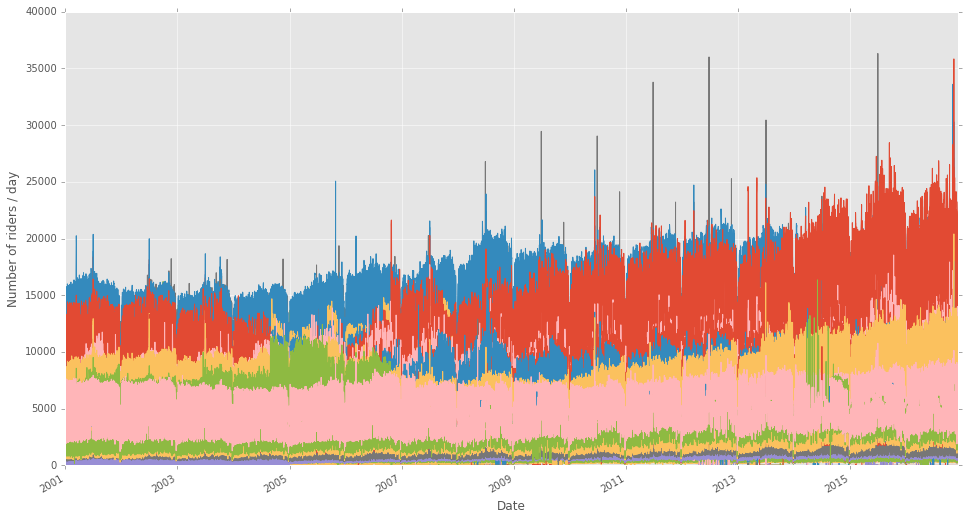

In [12]:
# Use groupby to get the data associated with each individual station
by_station = ridership.groupby(by='stationname')

# Get a visually dense timeseries plot to get a feel for the data
fh = plt.figure(figsize=(16,9))
ax = fh.add_subplot(111)
for station, df in by_station:
    df.plot(x='date', y='rides', ax=ax, label=station, legend=False, style={'linestyle':'None', 'marker': '.'})

daterange = plt.xlim()
plt.ylabel('Number of riders / day')
plt.xlabel('Date')
plt.show()

Well, that is not very useful. Let's calculate a moving average to smooth out the noise, and only look at the top 10 stations by average ridership to limit the distracting and dense data.

/home/chris/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=365,center=False).mean()
/home/chris/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


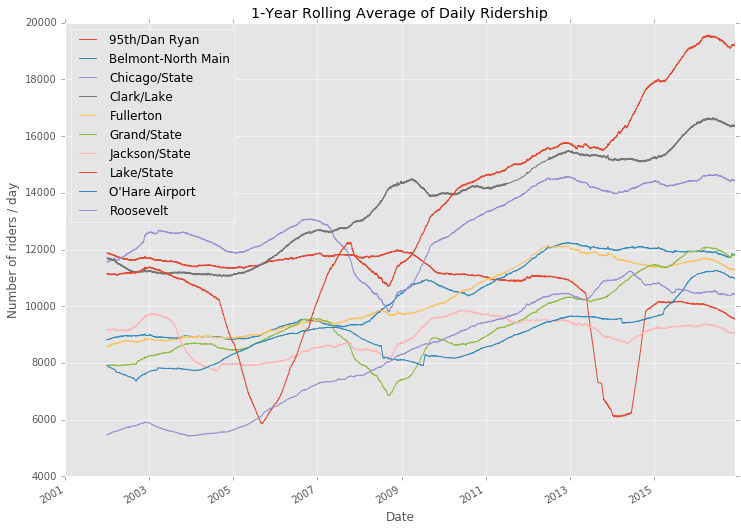

In [18]:
top_stations = mean_ridership.head(10).index.tolist()
# Get a useless but visually cool timeseries plot to get a feel for the data
fh = plt.figure(figsize=(12,9))
ax = fh.add_subplot(111)
for station, df in by_station:
    if station not in top_stations:
        continue
    # Take a 1-year rolling average of ridership
    df['rides'] = pd.rolling_mean(df['rides'], 365)
    df.plot(x='date', y='rides', ax=ax, label=station, legend=True)

daterange = plt.xlim()
plt.title('1-Year Rolling Average of Daily Ridership')
plt.ylabel('Number of riders / day')
plt.xlabel('Date')
plt.show()

Interesting! We can see that although Clark/Lake has the highest average ridership over the time frame, Lake/State has been growing the most quickly and currently has the highest average ridership over the last year. Let's drill into Lake/State and look at the weekly, monthly, and yearly trends more closely to see how we might use this information to choose a hypothetical new opening location.

## Making an interactive, data-layered map

When deciding whether to rent a new location, it might be very useful to have a map we can look at to visualize these ridership numbers and the proximity of potential locations to CTA stops. 

My idea for this map consists of differently colored circles placed on a real map colored based on the L line and sized based on the mean ridership numbers. Stops with multiple lines will have multiple circles in a Venn diagram, all the same size. Potential locations for rent can then be added to the map and visually compared for their proximity to different CTA lines.

In [13]:
import folium

Let's import the station locations from the open data portal.

In [14]:
station_locations = pd.read_json('https://data.cityofchicago.org/resource/8mj8-j3c4.json')
station_locations = station_locations.iloc[:,5:]
station_locations.g = [1.0 if station_locations.g[i] else 0.0 for i in range(station_locations.shape[0])]
station_locations.head(5)

,ada,blue,brn,direction_id,g,location,map_id,o,p,pexp,pnk,red,station_descriptive_name,station_name,stop_id,stop_name,y
0,True,0.0,0.0,W,0.0,"{'coordinates': [-87.669147, 41.857908], 'type...",40830,0.0,0.0,0.0,1.0,0.0,18th (Pink Line),18th,30162,18th (54th/Cermak-bound),0.0
1,True,0.0,0.0,E,0.0,"{'coordinates': [-87.669147, 41.857908], 'type...",40830,0.0,0.0,0.0,1.0,0.0,18th (Pink Line),18th,30161,18th (Loop-bound),0.0
2,True,0.0,0.0,N,0.0,"{'coordinates': [-87.680622, 41.829353], 'type...",40120,1.0,0.0,0.0,0.0,0.0,35th/Archer (Orange Line),35th/Archer,30022,35th/Archer (Loop-bound),0.0
3,True,0.0,0.0,S,0.0,"{'coordinates': [-87.680622, 41.829353], 'type...",40120,1.0,0.0,0.0,0.0,0.0,35th/Archer (Orange Line),35th/Archer,30023,35th/Archer (Midway-bound),0.0
4,True,0.0,0.0,S,1.0,"{'coordinates': [-87.625826, 41.831677], 'type...",41120,0.0,0.0,0.0,0.0,0.0,35th-Bronzeville-IIT (Green Line),35th-Bronzeville-IIT,30214,35-Bronzeville-IIT (63rd-bound),0.0


In [15]:
import numpy as np

# Create references for the names of the stations in the dataframes, and a map
# from the name to the standard CTA color for each line
cta_lines = ['blue', 'brn', 'g', 'o', 'p', 'pexp', 'pnk', 'red', 'y']
cta_colors = {'red': '#c60c30', 'blue': '#00a1de', 'brn': '#62361b', 'g': '#009b3a', 'o': '#f9461c', 'p': '#522398', 
          'pexp': '#8e57e0', 'pnk': '#e27ea6', 'y': '#f9e300'}

# Build dict of station name -> {location, cta_lines at location}
# The CTA stores their data such that for each entry in the station list,
# the box for each line that stops at that station is only checked if it is
# traveling in a given direction. We can just add up the total for each entry
# to have a simple indicator for whether the line stops there.
station_dict = {}
for index, station_data in station_locations.iterrows():
    id_no = station_data['map_id']
    if id_no in station_dict:
        station_dict[id_no]['cta_lines'] = station_dict[id_no]['cta_lines'] + station_data[cta_lines]
    else:
        station_dict[station_data['map_id']] = {'location': station_data['location']['coordinates'],
                                                  'id': station_data['map_id'], 
                                                  'cta_lines': station_data[cta_lines]}

In [16]:
# Create the map
cta_map = folium.Map(location=[41.881832, -87.623177], 
                     tiles='https://api.mapbox.com/styles/v1/mapbox/light-v9/tiles/256/{z}/{x}/{y}?access_token=pk.eyJ1IjoiY29vbG1hcHNicm8iLCJhIjoiY2oyY3Fxd2RnMDQ4aDMycXIxM2w4czRiMyJ9.7T7degT1VkMZSLn1Od1hVw', 
                     API_key='pk.eyJ1IjoiY29vbG1hcHNicm8iLCJhIjoiY2oyY3Fxd2RnMDQ4aDMycXIxM2w4czRiMyJ9.7T7degT1VkMZSLn1Od1hVw',
                     attr='Mapbox',
                     zoom_start=10)
misses = []
# Iterate through each station
for station_name, station_data in by_station:
    # There are duplicates, so pick out the first one and exctract its data
    id_no = station_data.iloc[0, :].loc['station_id']
    if id_no not in station_dict:
        misses.append(id_no)
        continue
    coords = station_dict[id_no]['location']
    station_loc = [coords[1], coords[0]]

    # Iterate through each of the lines
    for cta_line in cta_lines:
        if station_dict[id_no]['cta_lines'][cta_line] > 0.0:
            # If the line stops at that location, put down a marker!
            # Shift the position slightly based on color to avoid overlap
            shifter = cta_lines.index(cta_line)
            lat_shift = 0.0003 * np.sin(2*np.pi * shifter / len(cta_lines))
            lng_shift = 0.0003 * np.cos(2*np.pi * shifter / len(cta_lines))

            # Shape the marker based on the average ridership, scaled to make the size reasonable
            scaled_radius = np.sqrt(station_data['rides'].mean())
            avg_to_str = str(int(station_data['rides'].mean()))
            popup_string = station_name + ' - ' + avg_to_str + ' daily riders (avg)'

            folium.CircleMarker(location=[station_loc[0] + lat_shift, station_loc[1] + lng_shift],
                    radius=scaled_radius, 
                    popup=popup_string, color=cta_colors[cta_line],
                    fill_color=cta_colors[cta_line]).add_to(cta_map)
cta_map

Wow, very cool. We now have a colored map where the size of each dot tells us the average ridership (over the entire time period) and the color of each dot tells us whether the line stops at that location.

We can use this same technique to size the dots based on other factors like growth rate. Lots of possibilities!